## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 4-го спринта: "Создание рекомендательной системы"

## Этап 1. Первичная подготовка данных

### Постановка задачи

Прочитайте файлы с данными, проведите оценку данных на наличие проблем:
- Нужно ли изменить тип идентификаторов?
- Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

При необходимости решите найденные проблемы.

Сохраните предобработанные данные в удобном формате в двух файлах:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

### Описание исходных данных

Данные находятся в трёх файлах:

1. Данные о треках — в файле `tracks.parquet`:
    - `track_id` — идентификатор музыкального трека,
    - `albums` — список идентификаторов альбомов, содержащих трек,
    - `artists` — список идентификаторов исполнителей трека,
    - `genres` — список идентификаторов жанров, к которым принадлежит трек.

2. Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра),
    - `type` — тип идентификатора,
    - `name` — имя (название) каталожной единицы.

3. Данные о том, какие пользователи прослушали тот или иной трек — в файле `interactions.parquet`:
    - `user_id` — идентификатор пользователя,
    - `track_id` — идентификатор музыкального трека,
    - `track_seq` — номер места трека в истории пользователя,
    - `started_at` — дата начала прослушивания трека.

### Инициализация

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
import sys

# Проверяем, в каком окружении работаем
print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [3]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning))

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

### Загрузка данных

In [6]:
# Устанавливаем утилиту wget, если ее нет
!pip install wget

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for wget, since package 'wheel' is not installed.
  Running setup.py install for wget ... done


In [4]:
#!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
#!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet


Saved under interactions.parquet


### Предобработка данных

__Загружаем и проверяем данные из файла `tracks.parquet`__

In [6]:
tracks = pd.read_parquet("tracks.parquet")
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
# Смотрим типы колонок, кол-во строк, объем данных и наличие пропусков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Пропусков нет, типы корректны. Проверим `track_id` на наличие дубликатов и отрицательных значений.

In [8]:
# Проверяем track_id на наличие дубликатов 
print(f"Все track_id уникальны: {tracks['track_id'].nunique() == len(tracks)}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(tracks['track_id'] < 0).sum()}")

Все track_id уникальны: True
Кол-во отрицательных track_id: 0


Таким образом, повторяющихся и отрицательных track_id нет. 

После скачивания данных о каталогах мы также проверим, нет ли в колонках `albums`, `artists` и `genres` таблицы `tracks` идентификаторов, которые указывают на несуществующие каталожные единицы. В дальнейшем такие id будем игнорировать, для чего заменим их, например, на -1.

Что касается треков, у которых одновременно неопределены все три категории альбом/артист/жанр
либо неизвестно название самого трека, то мы не будем их удалять, т.к. они все равно могут попасть в историю взаимодействий, и, если они окажутся популярными, мы сможем рекомендавать их, например, "холодным" пользователям.

__Загружаем и проверяем данные из файла `catalog_names.parquet`__

In [9]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [10]:
# Смотрим типы колонок, кол-во строк и объем данных
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [11]:
# Проверяем наличие пропусков
catalog_names.isnull().sum()

id      0
type    0
name    0
dtype: int64

Пропусков нет, типы колонок корректны. Сделаем еще несколько проверок.

In [12]:
# Проверяем id на наличие повторяющихся значений
print(f"Кол-во уникальных id: {catalog_names['id'].nunique()}, общее кол-во строк: {len(catalog_names)}")

# Проверяем id на наличие отрицательных значений
print(f"Кол-во отрицательных id: {(catalog_names['id'] < 0).sum()}")

# Проверяем наличие полностью повторяющихся строк
duplicated_rows_condition = catalog_names.duplicated(catalog_names.columns, keep=False)
print(f"Кол-во полностью повторяющихся строк: {duplicated_rows_condition.sum()}")

Кол-во уникальных id: 1776697, общее кол-во строк: 1812471
Кол-во отрицательных id: 0
Кол-во полностью повторяющихся строк: 0


Отрицательных id и полностью повторяющихся строк нет, но есть повторяющиеся идентификаторы. 
Поскольку таких значений много, то вряд ли это связано со случайными ошибками.
Скорее всего внутри каждого типа есть своя идентификация. Убедимся в этом.

In [13]:
# Смотрим, какие есть каталожные типы
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [15]:
# Проверяем наличие повторяющихся id внутри типа album
cat_albums = catalog_names.query("type == 'album'")
print(f"Среди id альбомов нет повторяющихся значений: {cat_albums['id'].nunique() == len(cat_albums)}")

# Проверяем наличие повторяющихся id внутри типа artist
cat_artists = catalog_names.query("type == 'artist'")
print(f"Среди id артистов нет повторяющихся значений: {cat_artists['id'].nunique() == len(cat_artists)}")

# Проверяем наличие повторяющихся id внутри типа genre
cat_genres = catalog_names.query("type == 'genre'")
print(f"Среди id жанров нет повторяющихся значений: {cat_genres['id'].nunique() == len(cat_genres)}")

# Проверяем наличие повторяющихся id внутри типа track
cat_tracks = catalog_names.query("type == 'track'")
print(f"Среди id названий треков нет повторяющихся значений: {cat_tracks['id'].nunique() == len(cat_tracks)}")

Среди id альбомов нет повторяющихся значений: True
Среди id артистов нет повторяющихся значений: True
Среди id жанров нет повторяющихся значений: True
Среди id названий треков нет повторяющихся значений: True


Кол-во уникальных id внутри каждого типа равно общему кол-ву соответствующих каталожных единиц, значит повторяющихся id среди элементов одного типа действительно нет.

Далее вставим в таблицу треков названия соответствующих каталожных единиц вместо их идентификаторов. 
Это будет полезно, например, при визуальном оценивании качества рекомендаций.
Для этого развернем списки идентификаторов в `tracks` и вставим в полученную таблицу названия альбомов, артистов и жанров.
При этом в списках названий могут появиться пустые значения nan, но мы их удалим.

In [16]:
# Разворачиваем tracks по каталожным ids и переименовываем соответствующие колонки

tracks_exploded = tracks.explode('albums', ignore_index=True) \
    .explode('artists', ignore_index=True) \
        .explode('genres', ignore_index=True) \
            .rename(columns={'albums':'album_id', 'artists': 'artist_id', 'genres': 'genre_id'})

In [17]:
# Заменяем пропуски в id артистов, жанров и альбомов на -1, т.к.
# отрицательное число заведомо не совпадет ни с одним из id в таблице каталогов и 
# также это позволит нам привести тип object к int

tracks_exploded['album_id'].fillna(-1, inplace=True)
tracks_exploded['artist_id'].fillna(-1, inplace=True)
tracks_exploded['genre_id'].fillna(-1, inplace=True)

In [18]:
# Меняем тип object на int
tracks_exploded[['album_id', 'artist_id', 'genre_id']] = \
    tracks_exploded[['album_id', 'artist_id', 'genre_id']].astype('int')

In [19]:
# Вставляем в tracks_exploded имена альбомов
tracks_exploded = tracks_exploded \
    .merge(cat_albums[['id', 'name']], how='left', left_on='album_id', right_on='id') \
        .rename(columns={'name': 'album_name'}).drop(columns='id')

In [20]:
# Вставляем в tracks_exploded имена артистов
tracks_exploded = tracks_exploded \
    .merge(cat_artists[['id', 'name']], how='left', left_on='artist_id', right_on='id') \
        .rename(columns={'name': 'artist_name'}).drop(columns='id')

In [21]:
# Вставляем в tracks_exploded названия жанров
tracks_exploded = tracks_exploded\
    .merge(cat_genres[['id', 'name']], how='left', left_on='genre_id', right_on='id')\
        .rename(columns={'name': 'genre_name'}).drop(columns='id')

Сворачиваем полученный `tracks_exploded` по названиям альбомов, артистов и жанров, чтобы каждому треку соответствовала
одна строка, как это было в исходной таблице `tracks`. В конце добавляем названия треков.

In [24]:
# Удаляем колонки с id каталогов
tracks_exploded.drop(columns=['artist_id', 'genre_id', 'album_id'], inplace=True)

In [28]:
# Сворачиваем названия каталогов в списки
tracks = tracks_exploded.groupby('track_id') \
    .agg({'album_name': lambda x: x.tolist(), 'artist_name': lambda x: x.tolist(), 'genre_name': lambda x: x.tolist()}) \
        .rename({'album_name': 'albums', 'artist_name': 'artists', 'genre_name': 'genres'}, axis=1) \
            .reset_index()

In [30]:
# Удаляем повторяющиеся и пустые названия в списках каталогов
tracks['albums'] = tracks['albums'].apply(lambda names: list(set([name for name in names if str(name) != 'nan'])))
tracks['artists'] = tracks['artists'].apply(lambda names: list(set([name for name in names if str(name) != 'nan'])))
tracks['genres'] = tracks['genres'].apply(lambda names: list(set([name for name in names if str(name) != 'nan'])))

In [31]:
# Вставляем названия треков
tracks = tracks \
    .merge(cat_tracks[['id', 'name']], how='left', left_on='track_id', right_on='id') \
        .drop(columns='id')

__Загружаем и проверяем данные из файла `interactions.parquet`__

In [5]:
interactions = pd.read_parquet("interactions.parquet")
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [6]:
# Смотрим типы колонок, кол-во строк и объем данных
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [36]:
# Проверяем наличие пропусков
interactions.isnull().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Пропусков нет, однако типы идентификаторов `user_id` и `track_id` отличаются от int64. Перед тем, как это исправить, 
проверим корректность значений `user_id`, `track_id` и `track_seq`.

In [37]:
# Проверяем user_id на наличие отрицательных значений
print(f"Кол-во отрицательных user_id: {(interactions['user_id'] < 0).sum()}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(interactions['track_id'] < 0).sum()}")

# Проверяем track_seq на наличие отрицательных и нулевых значений (track_seq не могут быть нулевыми по смыслу)
print(f"Кол-во неположительных track_seq: {(interactions['track_seq'] <= 0).sum()}")

Кол-во отрицательных user_id: 0
Кол-во отрицательных track_id: 0
Кол-во неположительных track_seq: 0


Все целочисленные значения корректны, поэтому достаточно заменить тип колонок с идентификаторами. В противном случае пришлось бы  либо удалять отрицательные id, если их немного, либо пересчитывать, а именно, искать дополнение до 2**32 итд (т.к. отрицательные id могли появиться в результате ошибочного обрезания чисел с 64 до 32 бит).

In [38]:
# Приводим тип идентификаторов к int64
interactions[['user_id', 'track_id']] = interactions[['user_id', 'track_id']].astype('int64')

Также проверим, есть ли в `interactions` треки, которых нет в таблице `tracks`. Такие треки нужно будет удалить из `interactions`.

In [40]:
# Уникальные id всех прослушанных треков из таблицы interactions
played_tracks_ids = set(interactions['track_id'].unique()) 

# Уникальные id всех треков из таблицы tracks
# (выше мы уже убедились, что в таблице tracks все track_id уникальны)
all_tracks_ids = set(tracks['track_id'])
        
# Треки, которые есть interactions, но нет в tracks
wrong_tracks_ids = list(played_tracks_ids - all_tracks_ids)
print(f"Кол-во треков в interactions c неправильными id: {len(wrong_tracks_ids)}")

# Удаляем из interactions строки с неправильными track_id, если такие есть
if len(wrong_tracks_ids) > 0:
    interactions = interactions[~interactions['track_id'].isin(wrong_tracks_ids)]

Кол-во треков в interactions c неправильными id: 0


В конце переименуем таблицы `tracks`, `interactions`, а также их колонки `track_id` и `track_seq`, после чего сохраним полученные таблицы на диск.

In [41]:
# Переименовываем таблицы треков и взаимодействий
items = tracks.copy()
events = interactions.copy()

In [42]:
# Удаляем старые таблицы
del tracks
del interactions

In [43]:
# Переименовываем колонки track_id
items.rename(columns={'track_id': 'item_id'}, inplace=True)
events.rename(columns={'track_id': 'item_id', 'track_seq': 'item_seq'}, inplace=True)

In [44]:
# Сохраняем в файлы
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

## Этап 2. Анализ данных (EDA)

### Постановка задачи

Проведите EDA данных, чтобы получить представление о следущих параметрах:
- распределение количества прослушанных треков,
- наиболее популярные треки,
- наиболее популярные жанры,
- треки, которые никто не прослушал.

In [5]:
# Загружаем данные из файлов
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Посмотрим распределение кол-ва прослушиваний треков и уникальных пользователей по месяцам.

In [6]:
from pandas.tseries.offsets import MonthEnd

# Добавляем колонку с начальными датами для каждого месяца
events["started_at_month"] = events["started_at"].dt.to_period('M').dt.to_timestamp().dt.date

In [7]:
# Группируем события по месяцам
events_by_month = events.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

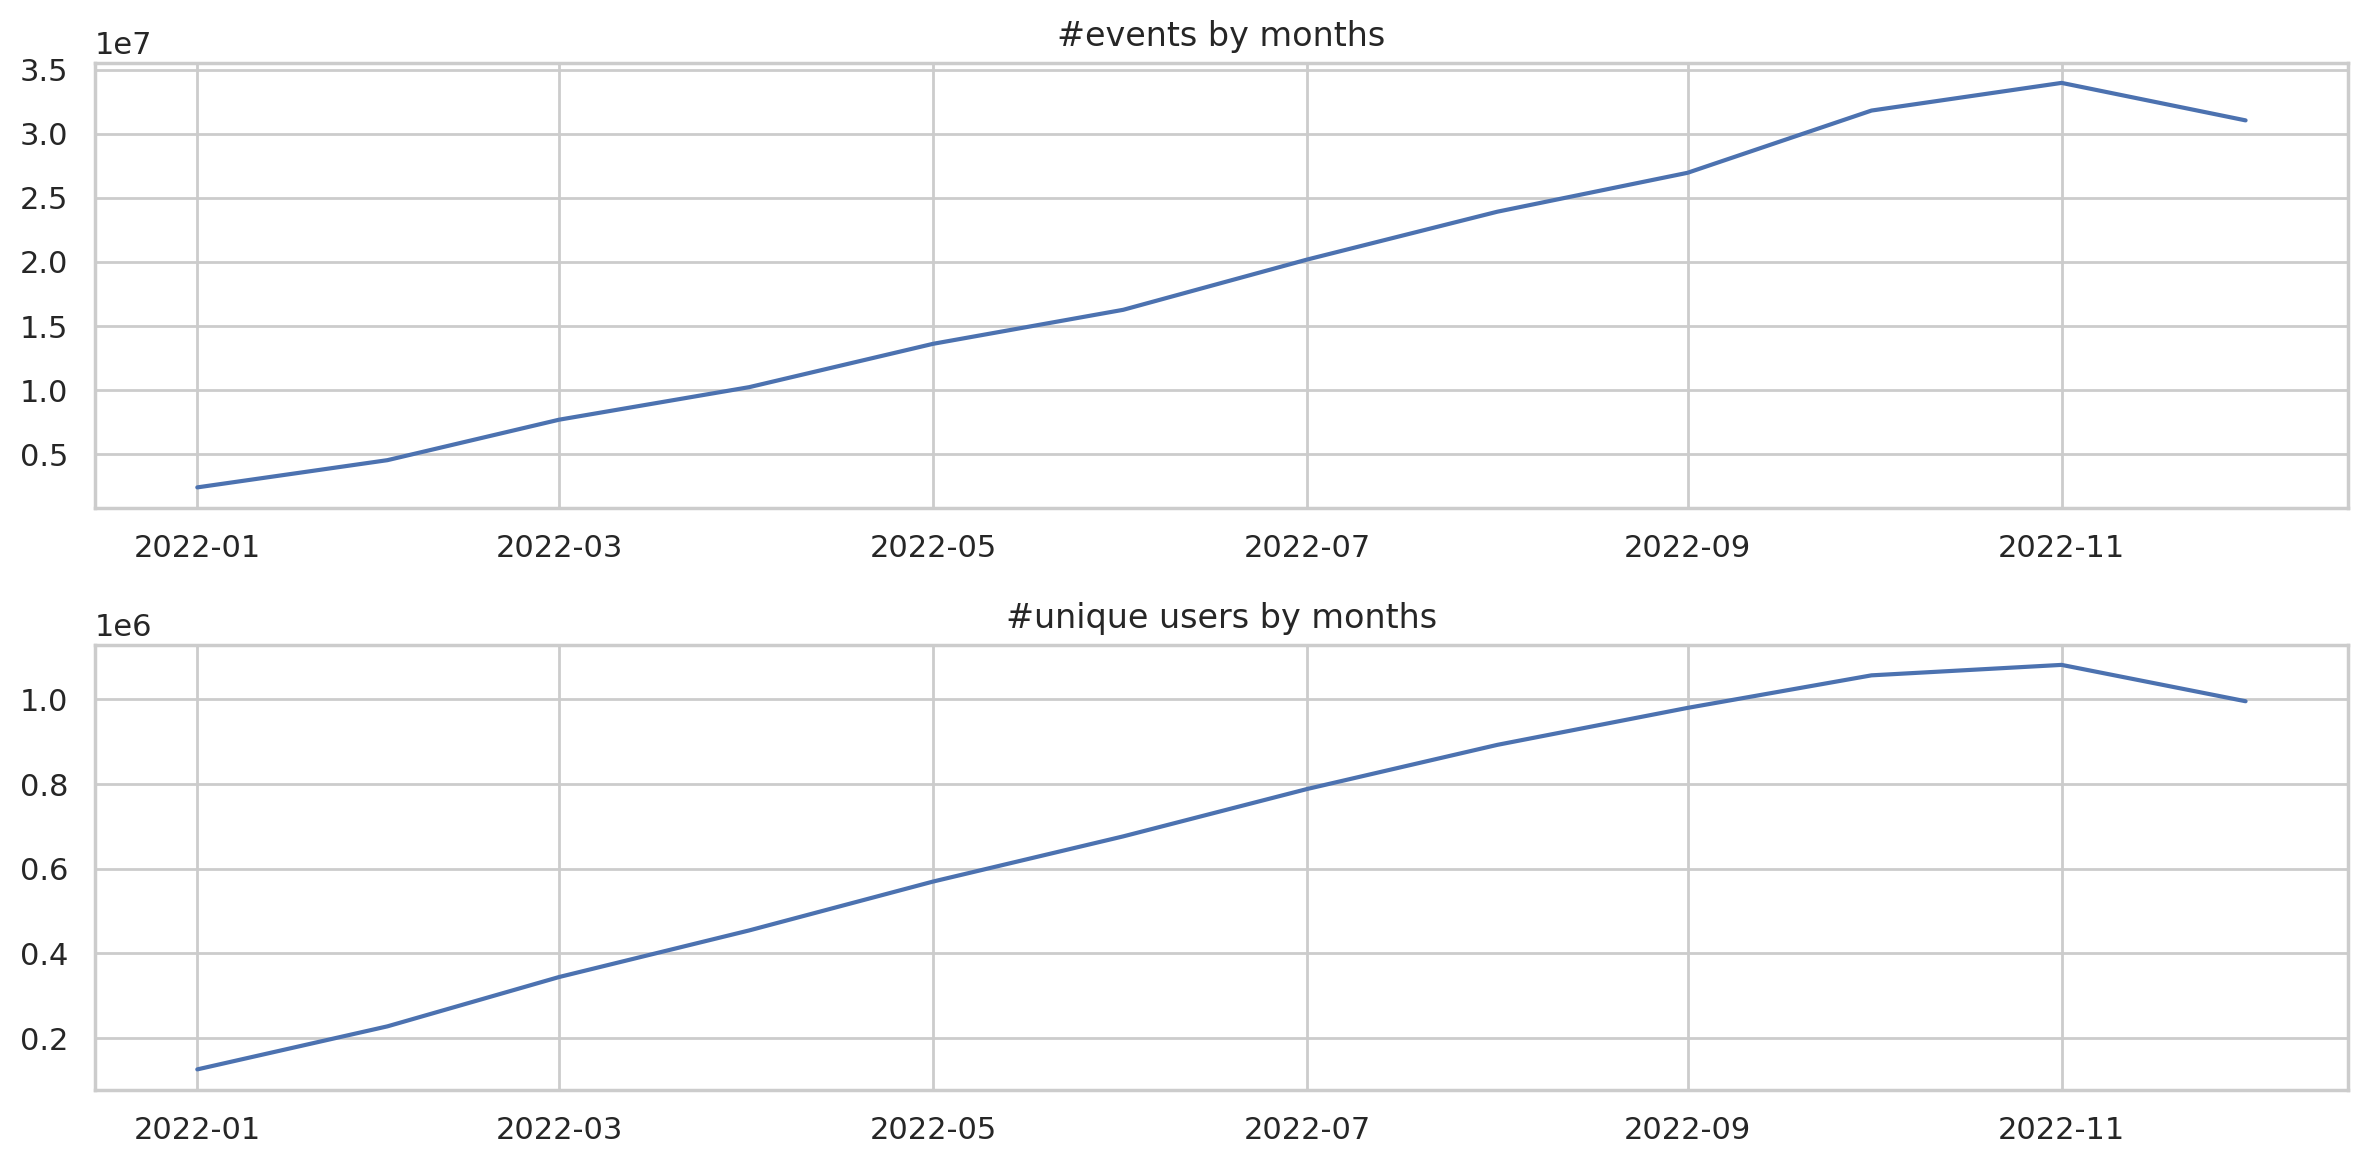

In [8]:
# Визуализируем распределение кол-ва взаимодействий и уникальных пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_by_month["started_at_month"], events_by_month["events"])
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_by_month["started_at_month"], events_by_month["users"])
ax.set_title("#unique users by months")

fig.tight_layout()

Видим, что история взимодействий охватывает только один 2022 год. Кол-во прослушиваний и уникальных пользователей постепенно росли вплоть до ноября, после чего начали немного снижаться. Возможно, сервис был запущен в самом начале 2022 г., и пик его популярности пришелся на конец года, после чего начал спадать.

Найдем топ-100 наиболее популярных треков по общему кол-ву прослушиваний.

In [18]:
pop_items = events \
    .groupby(["item_id"]).agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

# Сортируем по убыванию кол-ва прослушиваний, а при их равенстве - по убыванию пользователей
pop_items = pop_items.sort_values(['events', 'users'], ascending=[False, False])

# Выбираем первые 100 самых популярных айтемов 
top_k_pop_items = pop_items[:100].reset_index().drop(columns='index')

In [ ]:
# Добавляем колонки с названиями каталожных единиц
top_k_pop_items = top_k_pop_items \
    .merge(items[['item_id', 'name', 'genres', 'artists', 'albums']], how='inner', on='item_id')
top_k_pop_items

Сохраняем эти данные в файл `top_popular.parquet` для последующего использования в качестве готовых рекомендаций по умолчанию.

In [20]:
top_k_pop_items.to_parquet('top_popular.parquet')

Определим самые популярные жанры. Для этого пройдемся по только что отобранным топ-трекам и посчитаем, к каким жанрам они относятся. Тогда жанры с наибольшей встречаемостью будут являться самыми популярными.

In [36]:
# Функция для извлечения жанров из треков
def get_genres(items):

    """ 
    Извлекает жанры из треков и считает, сколько раз встречается каждый жанр.
    """    
    genres_counter = {}
    
    for k, v in items.iterrows():
        genres = list(v["genres"])

        for genre in genres:
            try:
                genres_counter[genre] += 1 
            except KeyError:
                genres_counter[genre] = 1

    genres = pd.Series(genres_counter, name="tracks")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
    genres.index.name = "genre_id"

    return genres

In [40]:
# Извлекаем жанры из самых популярных треков и считаем score для каждого жанра,
# как долю от общего кол-ва прослушиваний
top_k_pop_items_genres = get_genres(top_k_pop_items)
top_k_pop_items_genres["score"] = top_k_pop_items_genres["tracks"] / top_k_pop_items_genres["tracks"].sum()

Text(0.5, 1.0, 'Top 10 most played genres')

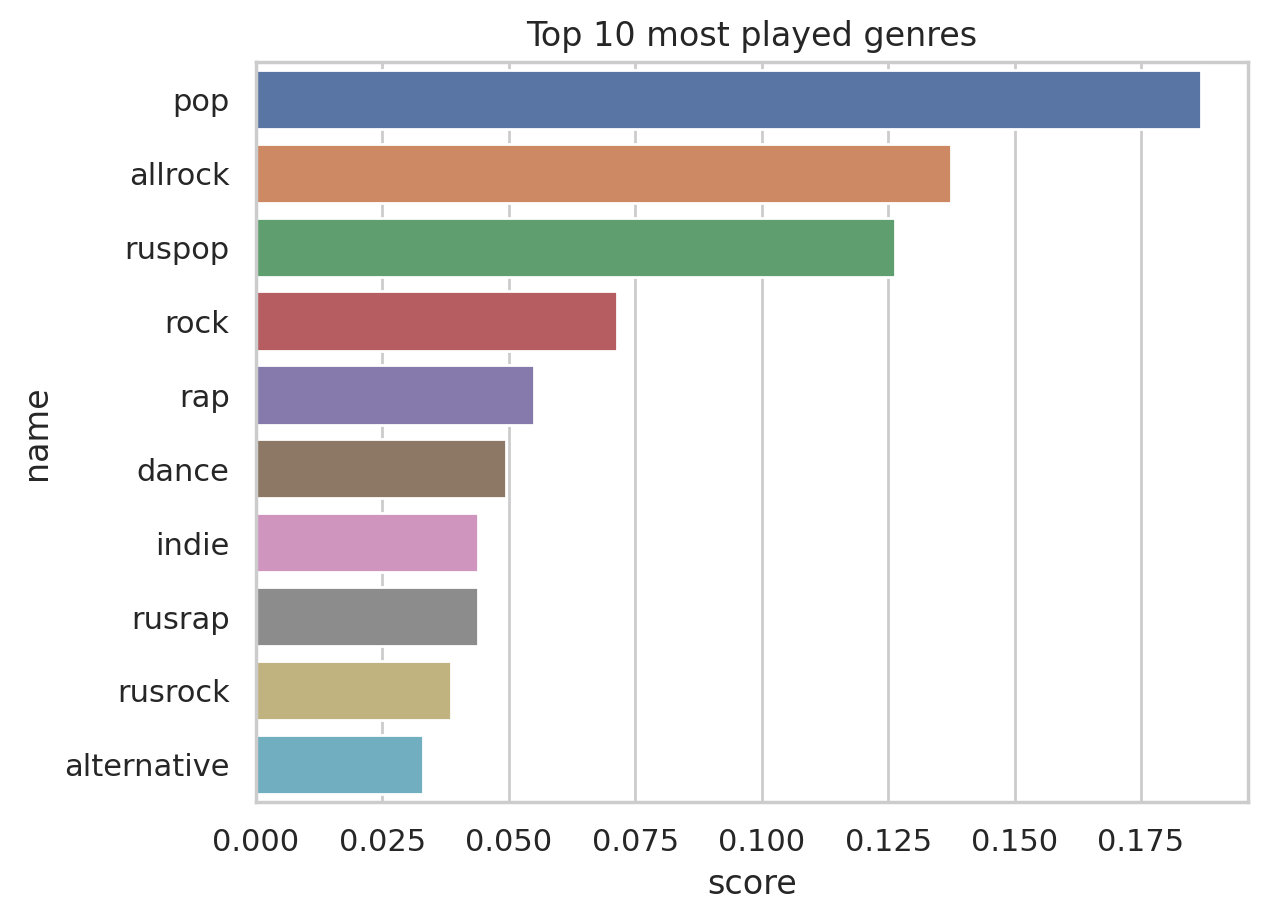

In [42]:
# Строим горизонтальный barplot
sns.barplot(data=top_k_pop_items_genres.sort_values(by="score", ascending=False).head(10), x='score', y='name').set_title("Top 10 most played genres")

Таким образом, в топ-100 самых прослушиваемых треков наиболее распространенным жанром является поп.

Также подготовим список жанров по всем трекам. Он понадобится нам для построения контентных рекомендаций.

In [ ]:
# Извлекаем жанры по всем трекам
genres = get_genres(items)
genres["score"] = genres["tracks"] / genres["tracks"].sum()

In [ ]:
# Смотрим отсортированный список
genres.sort_values(by="score", ascending=False).head(10)

Всего у нас получилось X жанров.

In [ ]:
# Сохраняем жанры в файл
genres.to_parquet('genres.parquet')

Находим треки, у которых нет прослушиваний в таблице взаимодействий.

In [ ]:
# Уникальные id всех треков
all_items_ids = set(items['item_id'])
        
# Уникальные id только прослушанных треков
played_items_ids = set(events['item_id'].unique()) 

# Треки, которых нет в events
not_played_items_ids = list(all_items_ids - played_items_ids)
print(f"Кол-во непрослушанных треков: {len(not_played_items_ids)}")

Непрослушанных треков нет.